In [21]:
import numpy as np
from scipy import random,linalg
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
import hdbscan
import pandas as pd
import numpy as np
import fastcluster
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

In [20]:
#!pip install fastcluster

     |████████████████████████████████| 155 kB 331 kB/s eta 0:00:01


In [3]:
"""
A function that creates symmetric Matrix which is posritive semidefinite
"""
def sym_matrix(n,state=3):
    matrixsize=n
    A=random.rand(matrixsize,matrixsize)
    B=np.dot(A,A.transpose())
    for i in range(n):
        B[i,i]=0
    return B


In [4]:
T=sym_matrix(20)

In [5]:
clusterer=hdbscan.HDBSCAN(min_cluster_size=30).fit(T)

In [6]:
clusterer.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

In [7]:
"""
An experiment with min_cluster_size
n: number of tests to be carried out
Starting from min_cluster_size 1
"""
def min_clus(n,T):
    for i in range(n):
        clusterer=hdbscan.HDBSCAN(min_cluster_size=i+2).fit(T)
        print(clusterer.labels_)
        
        
    


In [8]:
clusterer2 = hdbscan.HDBSCAN(cluster_selection_method='eom',min_cluster_size=5, min_samples=5,allow_single_cluster=True).fit(T)

In [9]:
clusterer2.labels_

array([ 0, -1,  0,  0, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0])

## More Clustering techniques

In [13]:
df2=pd.read_excel('corr.xlsx',sheet_name='Correlation')

In [24]:
"""
This is the correlation Matrix
"""
correl_mat=df2.to_numpy()

In [25]:
## The distnace matrix
dist = 1 - correl_mat

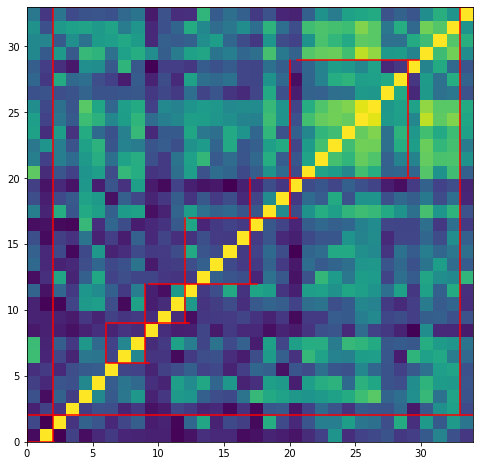

In [26]:
dim = len(dist)
tri_a, tri_b = np.triu_indices(dim, k=1)
Z = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
permutation = hierarchy.leaves_list(
    hierarchy.optimal_leaf_ordering(Z, dist[tri_a, tri_b]))
ordered_corr = correl_mat[permutation, :][:, permutation]

nb_clusters = 7
clustering_inds = fcluster(Z, nb_clusters, criterion='maxclust')
clusters = {i: [] for i in range(min(clustering_inds),
                                 max(clustering_inds) + 1)}
for i, v in enumerate(clustering_inds):
    clusters[v].append(i)
    
plt.figure(figsize=(8, 8))
plt.pcolormesh(correl_mat)
for cluster_id, cluster in clusters.items():
    xmin, xmax = min(cluster), max(cluster)
    ymin, ymax = min(cluster), max(cluster)
    
    plt.axvline(x=xmin,
                ymin=ymin / dim, ymax=(ymax + 1) / dim,
                color='r')
    plt.axvline(x=xmax + 1,
                ymin=ymin / dim, ymax=(ymax + 1) / dim,
                color='r')
    plt.axhline(y=ymin,
                xmin=xmin / dim, xmax=(xmax + 1) / dim,
                color='r')
    plt.axhline(y=ymax + 1,
                xmin=xmin / dim, xmax=(xmax + 1) / dim,
                color='r')
plt.show()

In [27]:
for id_cluster, cluster in clusters.items():
    print(id_cluster - 1, ':', cluster)

0 : [12, 13, 14, 15, 16]
1 : [17, 18, 19]
2 : [9, 10, 11]
3 : [0, 1]
4 : [6, 7, 8]
5 : [20, 21, 22, 23, 24, 25, 26, 27, 28]
6 : [2, 3, 4, 5, 29, 30, 31, 32]


In [28]:
def seriation(Z, dim, cur_index):
    if cur_index < dim:
        return [cur_index]
    else:
        left = int(Z[cur_index - dim, 0])
        right = int(Z[cur_index - dim, 1])
        return seriation(Z, dim, left) + seriation(Z, dim, right)
    
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [29]:
def compute_allocation(covar, clusters):
    nb_clusters = len(clusters)
    assets_weights = np.array([1.] * len(covar))
    clusters_weights = np.array([1.] * nb_clusters)
    clusters_var = np.array([0.] * nb_clusters)
    
    for id_cluster, cluster in clusters.items():
        cluster_covar = covar[cluster, :][:, cluster]
        inv_diag = 1 / np.diag(cluster_covar)
        assets_weights[cluster] = inv_diag / np.sum(inv_diag)
        
    for id_cluster, cluster in clusters.items():
        weights = assets_weights[cluster]
        clusters_var[id_cluster - 1] = np.dot(
            weights, np.dot(covar[cluster, :][:, cluster], weights))
        
    for merge in range(nb_clusters - 1):
        print('id merge:', merge)
        left = int(Z[dim - 2 - merge, 0])
        right = int(Z[dim - 2 - merge, 1])
        left_cluster = seriation(Z, dim, left)
        right_cluster = seriation(Z, dim, right)

        print(len(left_cluster),
              len(right_cluster))

        ids_left_cluster = []
        ids_right_cluster = []
        for id_cluster, cluster in clusters.items():
            if sorted(intersection(left_cluster, cluster)) == sorted(cluster):
                ids_left_cluster.append(id_cluster)
            if sorted(intersection(right_cluster, cluster)) == sorted(cluster):
                ids_right_cluster.append(id_cluster)


        ids_left_cluster = np.array(ids_left_cluster) - 1
        ids_right_cluster = np.array(ids_right_cluster) - 1
        print(ids_left_cluster)
        print(ids_right_cluster)
        print()

        alpha = 0
        left_cluster_var = np.sum(clusters_var[ids_left_cluster])
        right_cluster_var = np.sum(clusters_var[ids_right_cluster])
        alpha = left_cluster_var / (left_cluster_var + right_cluster_var)

        clusters_weights[ids_left_cluster] = clusters_weights[
            ids_left_cluster] * alpha
        clusters_weights[ids_right_cluster] = clusters_weights[
            ids_right_cluster] * (1 - alpha)

    for id_cluster, cluster in clusters.items():
        assets_weights[cluster] = assets_weights[cluster] * clusters_weights[
            id_cluster - 1]
        
    return assets_weights

In [30]:
weights = compute_allocation(correl_mat, clusters)

id merge: 0
11 22
[0 1 2]
[3 4 5 6]

id merge: 1
2 20
[3]
[4 5 6]

id merge: 2
3 17
[4]
[5 6]

id merge: 3
5 6
[0]
[1 2]

id merge: 4
3 3
[1]
[2]

id merge: 5
9 8
[5]
[6]



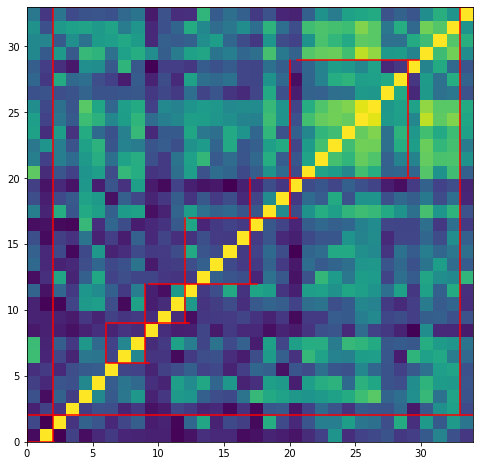

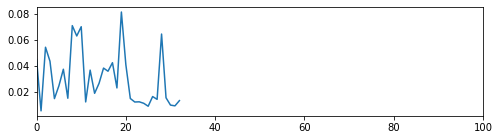

In [31]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(correl_mat)
for cluster_id, cluster in clusters.items():
    xmin, xmax = min(cluster), max(cluster)
    ymin, ymax = min(cluster), max(cluster)
    
    plt.axvline(x=xmin,
                ymin=ymin / dim, ymax=(ymax+1) / dim,
                color='r')
    plt.axvline(x=xmax+1,
                ymin=ymin / dim, ymax=(ymax+1) / dim,
                color='r')
    plt.axhline(y=ymin,
                xmin=xmin / dim, xmax=(xmax+1) / dim,
                color='r')
    plt.axhline(y=ymax+1,
                xmin=xmin / dim, xmax=(xmax+1) / dim,
                color='r')
plt.show()
plt.figure(figsize=(8, 2))
plt.plot(weights)
plt.xlim([0, 100])
plt.show()